# How I Developed a Real Automated Trading System Using Machine Learning

Please note that this notebook is using a data set that you will not have access to and that feature names have been anonymized.  I also import a library called system_demo that will not be shared at this time.  The reason for this is that I am currently trading this system at my firm.

I hope to use this notebook to illustrate how using EDA I determined which features were the most important.  It's actualy in this EDA step that I built my live system.  However, this notebook does take it a step further and show how to build an ML model for this data set.

### 1. Understand the Problem

This as a supervised classification problem.  The label column is % gain on the trade.  We will clasify a winning trade as 0.05% gain.  This may seem like a small gain but these trades and this data is for a system to hold trades for extremely short periods of time and to use high leverage.

In [1]:
from system_demo import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Data Collection & Cleaning

In [2]:
#Load raw data
full_df = load_filtered_df('2017 Jan-May Data.csv')

In [3]:
#Add custom features - from system_demo
full_df = add_new_features(full_df)

In [4]:
#Anonymize data - from system_demo
df = full_df[COLS_TO_SHOW].copy()
df.columns = COL_NAMES
df.head()

,Date,X1,X2,X3A,X3B,X3C,X4A,X4B,X4C,X5,X6A,X6B,X6C,X7,Label
9,20170112,90900.0,2.16,66.33,0.35,0.23,1.330893,0.843228,0.904478,6050304.0,0.008403,-0.042017,-0.033613,0.0216,0.05
10,20170112,261800.0,1.21,59.20,0.07,0.04,4.768670,0.808025,0.880592,15509032.0,-0.000000,-0.008264,-0.000000,0.0121,-0.00
18,20170112,95300.0,1.18,96.14,0.23,0.22,0.672548,0.732513,0.850134,9141176.0,0.071685,0.060932,0.032258,0.0118,-0.03
21,20170112,65700.0,1.20,93.66,0.29,0.27,0.557725,0.717249,0.744898,6171201.0,0.039474,0.065789,0.065789,0.0120,0.05
26,20170112,68700.0,1.83,77.12,0.23,0.18,0.604222,0.535881,0.571072,5285778.0,0.078652,0.033708,0.056180,0.0183,-0.08


In [5]:
df.dtypes

Date       int64
X1       float64
X2       float64
X3A      float64
X3B      float64
X3C      float64
X4A      float64
X4B      float64
X4C      float64
X5       float64
X6A      float64
X6B      float64
X6C      float64
X7       float64
Label    float64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3664 entries, 9 to 9711
Data columns (total 15 columns):
Date     3664 non-null int64
X1       3664 non-null float64
X2       3664 non-null float64
X3A      3664 non-null float64
X3B      3664 non-null float64
X3C      3664 non-null float64
X4A      3664 non-null float64
X4B      3664 non-null float64
X4C      3664 non-null float64
X5       3664 non-null float64
X6A      3664 non-null float64
X6B      3664 non-null float64
X6C      3664 non-null float64
X7       3664 non-null float64
Label    3664 non-null float64
dtypes: float64(14), int64(1)
memory usage: 458.0 KB


Data looks good, all in numerical format and no null values to deal with.  One thing I will do here, before the exploratory data analysis, is to split my data into a train and test set.  

Since this is time series data it would potentially be biased to sample randomly from the data set as we could be looking at future info to make predictions on older data points.  Therefore I will split the data by withholding the month of May as my test set.

In [7]:
#Split into train & test sets -> do not want look-ahead bias during EDA
df_train = df[df['Date'] < 20170501].copy()
df_test = df[df['Date'] >= 20170501].copy()

### 3. Explore & Understand the Data

First let's get a basic feel for the data we have, then look at which variables can drive the results the most.

##### Quantitative EDA

In [8]:
#Describe
df_train.describe()

,Date,X1,X2,X3A,X3B,X3C,X4A,X4B,X4C,X5,X6A,X6B,X6C,X7,Label
count,2.873000e+03,2.873000e+03,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2.873000e+03,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000
mean,2.017027e+07,9.646568e+04,3.483568,80.987386,9.582001,7.685952,0.622273,0.820762,1.011360,6.971280e+06,0.048562,0.024737,0.014404,inf,0.011504
std,1.107518e+02,1.211039e+05,4.971668,264.524693,341.611339,261.475330,0.481314,7.187268,7.194544,9.163320e+06,0.119415,0.076083,0.046524,NaN,0.071960
min,2.017010e+07,1.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000508,-1.000000,-1.000000,5.059000e+03,-1.090909,-0.405063,-0.368421,0.000100,-0.700000
25%,2.017013e+07,4.570000e+04,1.010000,49.920000,0.140000,0.080000,0.352727,0.411849,0.488404,2.488176e+06,-0.021739,-0.018182,-0.010417,0.010200,-0.020000
50%,2.017030e+07,6.510000e+04,2.040000,66.970000,0.250000,0.160000,0.577052,0.648840,0.732381,4.413982e+06,0.041509,0.019417,0.011905,0.020400,0.010000
75%,2.017033e+07,1.083000e+05,3.810000,88.250000,0.390000,0.290000,0.771642,0.828317,0.901126,8.127087e+06,0.106667,0.063158,0.037736,0.038200,0.040000
max,2.017043e+07,2.802700e+06,81.080000,9999.950000,16374.380000,9939.250000,7.337066,379.000000,291.000000,1.961049e+08,1.183673,0.877551,0.551020,inf,0.680000


In [9]:
#Correlation with All
df_train.corr()

,Date,X1,X2,X3A,X3B,X3C,X4A,X4B,X4C,X5,X6A,X6B,X6C,X7,Label
Date,1.000000,-0.025951,0.057889,-0.010912,-0.003303,-0.011518,-0.062146,-0.000179,0.001349,-0.017054,0.031245,0.001706,-0.000136,0.057573,-0.101219
X1,-0.025951,1.000000,0.369765,0.050181,0.051927,0.060750,0.344406,0.026983,0.013400,0.827705,0.204267,0.220300,0.261155,0.369400,0.214303
X2,0.057889,0.369765,1.000000,0.127957,0.146090,0.131493,0.200945,0.011766,0.008047,0.398436,0.228761,0.185478,0.161093,1.000000,0.187344
X3A,-0.010912,0.050181,0.127957,1.000000,0.938474,0.989207,0.068694,0.004401,0.003128,0.126169,0.104618,0.146011,0.124728,0.127940,0.168179
X3B,-0.003303,0.051927,0.146090,0.938474,1.000000,0.949627,0.087795,0.002198,-0.000855,0.063801,0.101456,0.146172,0.104015,0.146107,0.139351
X3C,-0.011518,0.060750,0.131493,0.989207,0.949627,1.000000,0.076265,0.001684,-0.000880,0.086623,0.101862,0.139547,0.115954,0.131505,0.168594
X4A,-0.062146,0.344406,0.200945,0.068694,0.087795,0.076265,1.000000,0.059481,0.065178,0.322830,0.111154,0.127729,0.132111,0.200226,0.130974
X4B,-0.000179,0.026983,0.011766,0.004401,0.002198,0.001684,0.059481,1.000000,-0.002169,0.039649,-0.027958,0.001445,0.014013,0.011651,-0.000592
X4C,0.001349,0.013400,0.008047,0.003128,-0.000855,-0.000880,0.065178,-0.002169,1.000000,0.022778,0.004741,0.012033,0.017637,0.007912,-0.001273
X5,-0.017054,0.827705,0.398436,0.126169,0.063801,0.086623,0.322830,0.039649,0.022778,1.000000,0.228621,0.254262,0.303559,0.398102,0.235790


In [10]:
#Correlation with Label
df_train.corr()['Label']

Date    -0.101219
X1       0.214303
X2       0.187344
X3A      0.168179
X3B      0.139351
X3C      0.168594
X4A      0.130974
X4B     -0.000592
X4C     -0.001273
X5       0.235790
X6A     -0.096230
X6B     -0.054533
X6C     -0.017037
X7       0.186959
Label    1.000000
Name: Label, dtype: float64

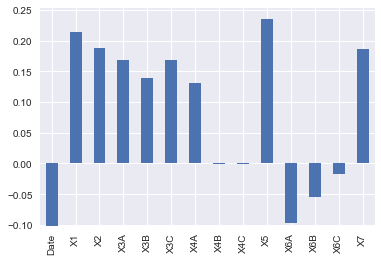

In [11]:
corrs = df_train.corr()['Label']
corrs.drop('Label').plot(kind='bar');

Looking at the variable correlation with our target variable we see that X5, X1, X7, and X2 are most correlated.  However, upon further inspection we see that X5 is pretty closely correlated with X1, and that X7 and X2 are perfectly correlated.  We should therefore throw out X7 since there isn't any information gain using both X7 and X2, and we should consider removing X1 in favor of just X5.  

Let's now examine these variables more closely against our target.

##### Visual EDA

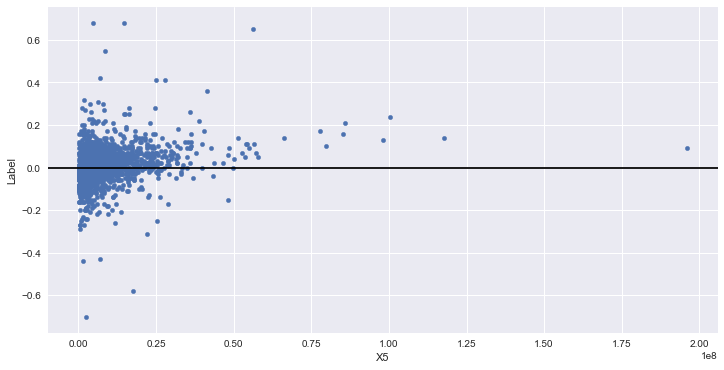

In [12]:
#Plot vs results

#X5
df_train.plot(x='X5', y='Label', kind='scatter', figsize=(12,6))
plt.axhline(0, color='k')
plt.show()

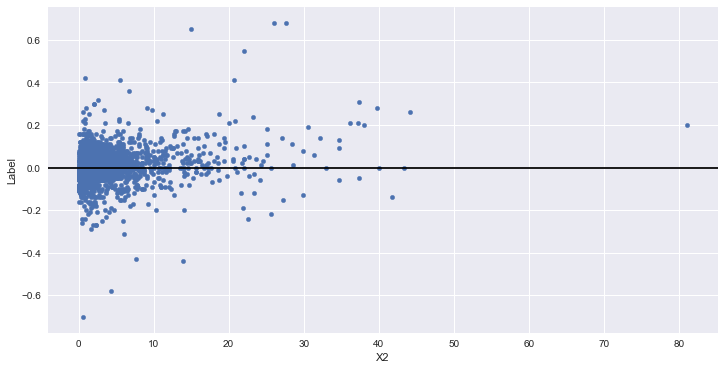

In [13]:
#X2
df_train.plot(x='X2', y='Label', kind='scatter', figsize=(12,6))
plt.axhline(0, color='k')
plt.show()

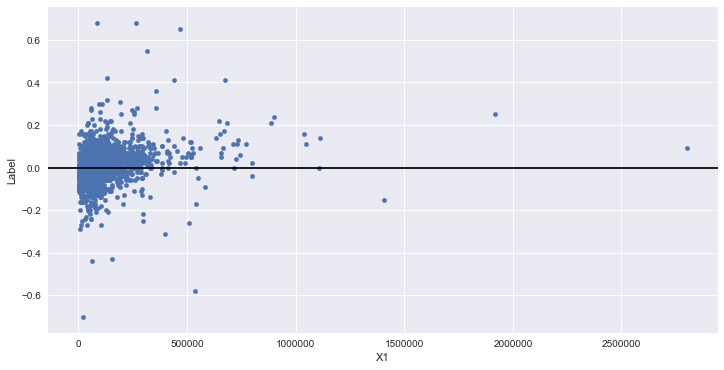

In [14]:
#X1
df_train.plot(x='X1', y='Label', kind='scatter', figsize=(12,6))
plt.axhline(0, color='k')
plt.show()

To find a profitable trading system we are looking for the parameters that have more dots above the black line (capture as many winning trades as possible).  The further right we get in all these charts, the better the results seem to look.  Remember these 3 variables had the highest correlation to the result label across the entire dataset.

In trading there is a lot of noise, but we don't have to take every trade.  We can filter out a lot of the noise by increasing the values these 3 features need before taking a trade.

My current live system is trading just on these 3 parameters here.  I didn't even get to the machine learning stage because the insights from this visual EDA led me to a profitable system that was optimal enough to go live with.  I did write a function to split my data on these features and associated values, and then would get my backtested pnl (this helped narrow down some parameters easier).

### 4. Prepare Data for Machine Learning

Not much needs to be done in this step now.  Before our EDA we converted everything to numerical values and we added the features I engineered previously.  Now we need to define our labels and then get our data into numpy arrays for machine learning.

##### Define Labels
For this trading problem I just want to know when to trade and when to pass on the signal.  Therefore I will frame this as a binary classification problem.  To do this I will set a threshold on the result's column (Label) that will turn it into a binary column.  So if the result percent is above 0.05% then I want to trade it (set to 1), else I want to pass on the trade (set to 0).  I chose this threshold to factor in slippage and transaction costs.

It should be noted that the Label column is the trade percent gain.  So if the trade was a short, and the move was down, the label would be positive since that trade was a winning trade.


In [15]:
df_train['Label_binary'] = np.where(df_train['Label']>=0.05, 1, 0)
df_test['Label_binary'] = np.where(df_test['Label']>=0.05, 1, 0)

##### Clean Up Data

In building this notebook I came across a "ValueError: Input contains NaN, infinity or a value too large for dtype('float32')" when building my ML model below.  Turns out there were a few infinity values in the dataframe so let's take care of that now.  These infinity values are the result of a division operation during the add_new_features().

In [17]:
#Check for NaN's
np.any(np.isnan(df_train))

False

In [18]:
#Check and get location for any Infinity values
np.where(df_train >= np.finfo(np.float64).max)

(array([ 369, 1355, 2130], dtype=int64), array([13, 13, 13], dtype=int64))

In [19]:
#Inspect
df_train.iloc[369]

Date            2.017012e+07
X1              1.000000e+02
X2              0.000000e+00
X3A             5.059000e+01
X3B             0.000000e+00
X3C             0.000000e+00
X4A             9.560229e-04
X4B             1.919386e-03
X4C             1.597444e-03
X5              5.059000e+03
X6A             5.263158e-02
X6B             0.000000e+00
X6C             0.000000e+00
X7                       inf
Label          -6.000000e-02
Label_binary    0.000000e+00
Name: 1046, dtype: float64

In [20]:
#Replace Inf with 0
df_train.replace([np.inf, -np.inf], 0, inplace=True)

In [21]:
#Ensure no more NaN or Inf
np.all(np.isfinite(df_train))

True

##### Split data into train and test sets

Our month of May test set will be held out completely from this cross-validation and used as a test for the final model.  The current df_train will be used to build the model.

In [22]:
from sklearn.model_selection import TimeSeriesSplit

#This train set will be split during the CV into train and test sets
X_train = df_train.drop(['Label', 'Label_binary'], axis=1).values
y_train = df_train['Label_binary'].values

#This test set is for final evaluation
X_test = df_test.drop(['Label', 'Label_binary'], axis=1).values
y_test = df_test['Label_binary'].values

### 5. Modeling

Now we can begin running CV to build an ML model.  There are lot of different ways to approach the modeling of this problem but I wll show a few ways here.

In [23]:
from sklearn.model_selection import cross_val_score

def run_time_series_cross_validation(classifer, X_train, Y_train, scoring='accuracy', n_splits=5, random_state=7):
    '''(sklearn classifierd, array, array, int, int) -> list of floats (scores)
    
    This will act as a test-harness to split the time series data and
    run cross val score using our model.  Will return the list of
    scores as well as print the mean.
    '''
    cv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(classifer, X_train, Y_train, cv=cv, scoring=scoring)
    print "Avg. Score: " + str(scores.mean())
    print "Min Score: " + str(scores.min())
    print "Max Score: " + str(scores.max())
    return scores

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
run_time_series_cross_validation(rf, X_train, y_train)

Avg. Score: 0.751046025105
Min Score: 0.6589958159
Max Score: 0.81589958159


array([ 0.65899582,  0.71966527,  0.74895397,  0.81171548,  0.81589958])

### 6. Evaluate & Tune Model

Now I will use GridSearch to optimize the RandomForest model.  After this we can build our final model, get predictions, and then translate those predictions into potential trading PnL.

##### Optimizing with GridSearchCV

In [25]:
from sklearn.model_selection import GridSearchCV

#Parameter dictionary for gridsearch
params = {'max_depth': [5, 8, 15, 25],
          'min_samples_split': [2, 5, 10, 15],
          'max_features': ['log2', 'auto', None]}
#Initialize Model
rf = RandomForestClassifier(n_estimators=100)
#Initialize GridSearch
cv = TimeSeriesSplit(n_splits=5)
grid_cv = GridSearchCV(rf, params, cv=cv)
#Fit GridSearch
grid_cv.fit(X_train, y_train)
#Get Best Results
print "Best Score: {}, Best Parameters: {}".format(grid_cv.best_score_, grid_cv.best_params_)

Best Score: 0.761506276151, Best Parameters: {'max_features': 'log2', 'min_samples_split': 15, 'max_depth': 5}


In [26]:
#Expand the GridSearch

#Parameter dictionary for gridsearch
params = {'max_depth': [2, 3, 4, 5],
          'min_samples_split': [15, 20, 25, 40],
          'max_features': ['log2', 'auto', None]}
#Initialize Model
rf = RandomForestClassifier(n_estimators=100)
#Initialize GridSearch
cv = TimeSeriesSplit(n_splits=5)
grid_cv = GridSearchCV(rf, params, cv=cv)
#Fit GridSearch
grid_cv.fit(X_train, y_train)
#Get Best Results
print "Best Score: {}, Best Parameters: {}".format(grid_cv.best_score_, grid_cv.best_params_)

Best Score: 0.761506276151, Best Parameters: {'max_features': 'auto', 'min_samples_split': 25, 'max_depth': 4}


##### Build & Train Final Model

In [27]:
#Initialize Optimal Model
rf = RandomForestClassifier(n_estimators=5000, max_features='log2', min_samples_split=20, max_depth=3)
#Train Model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=5000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

##### Get Predictions from Model

In [28]:
#Make Predictions on Train & Test set for evaluation
in_sample_pred = rf.predict(X_train) #Should be better than out of sample
out_sample_pred = rf.predict(X_test)

In [29]:
np.unique(in_sample_pred, return_counts=True)

(array([0, 1]), array([2790,   83], dtype=int64))

In [30]:
np.unique(out_sample_pred, return_counts=True)

(array([0, 1]), array([752,  39], dtype=int64))

##### Convert Predictions into Trading PnL

In [31]:
def add_trading_pnl_from_predictions(df, preds):
    '''(DataFrame, Array) -> DataFrame
    
    Given a dataframe of trades and array of binary predictions,
    calculate the trading performance if traded off the predictions.
    Assumes the PnL column in the dataframe is called 'Label'.
    Will create the column 'PnL' and return the new dataframe.
    '''
    df['Prediction'] = preds
    #Label is positive if winner, negative if loser
    #Prediction is 1 if trade, 0 if pass
    df['PnL'] = df.apply(lambda row: row['Prediction']*row['Label'], axis=1)
    return df

In [32]:
#Gross PnL - In Sample
df_train = add_trading_pnl_from_predictions(df_train, in_sample_pred)
df_train['PnL'].sum()

9.870000000000001

In [33]:
#Gross PnL - Out of Sample
df_test = add_trading_pnl_from_predictions(df_test, out_sample_pred)
df_test['PnL'].sum()

3.6

In [38]:
#Trade Count - In Sample
df_train['Prediction'].sum()

83

In [39]:
#Trade Count- Out of Sample
df_test['Prediction'].sum()

39

In [36]:
#Get Percent Gain per Trade - In Sample
df_train['PnL'].sum() / df_train['Prediction'].sum()

0.11891566265060242

In [37]:
#Get Percent Gain per Trade - Out of Sample
df_test['PnL'].sum() / df_test['Prediction'].sum()

0.092307692307692313

### 7. Present Results

This simple random forest model predicted 83 in sample trades that would result in a return of 9.87% with an average gain of 0.12% per trade.  We had an out of sample prediction (on one month of data) of 39 trades that would have returned 3.60% with an average gain of 0.09% per trade.

On a percentage basis like this, these results might not sound too impressive, but this strategy is traded at my firm using high leverage because the holding time is extremely short for this system.  Also, as I mentioned earlier, the model I trade live on this data was determined from the EDA, not this random forest.  My EDA rules do result in some similar returns and gains per trade.  

I like the return per trade as metric because each trade involves a transaction cost and comes with some execution slippage.  So being able to maximize that return per trade will give you a better chance to overcome those costs and be net profitable.

##### Next Steps
-Try other ML algorithms  
-Change the label - make the threshold bigger for when to trade  
-Try to extract more features

Thank you for taking the time to read this notebook, I apologize for the need to keep most of this data and code anonymous but I hope you were able to learn something.  If in the future I stop running this system live, I will release the code.
